# Problem Set # 5

### MACS 30100, Dr. Evans
### Zunda Xu ( zunda@uchicago.edu )

First, we import the packages used in this assignment.

In [2]:
# Import packages
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from pylab import rcParams
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

/Users/winston/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/winston/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Problem 1 : Multinomial logistic regression and cross validation

First of all, we will import the dataset used in this problem.

In [169]:
# Import dataset
strongdrink = pd.read_csv("strongdrink.txt")
strongdrink.columns = ['cultivar','alco','malic','ash','alk','magn','tot_phen',
                   'flav','nonfl_phen','proanth','color_int','hue','OD280rat','proline']
strongdrink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### Part ( a ) : Estimate the multinomial logistic regression model

In [170]:
# Generate the new dataset which only contains the columns used in the model
strongdrink = strongdrink[['cultivar', 'alco', 'malic', 'tot_phen', 'color_int']]
strongdrink.head()

,cultivar,alco,malic,tot_phen,color_int
0,1,14.23,1.71,2.80,5.64
1,1,13.20,1.78,2.65,4.38
2,1,13.16,2.36,2.80,5.68
3,1,14.37,1.95,3.85,7.80
4,1,13.24,2.59,2.80,4.32


##### (1) Estimate the model on a 75% sample training set and report the two sets of estimated coefficients

In [171]:
X = strongdrink[['alco', 'malic', 'tot_phen', 'color_int']]
y = strongdrink[['cultivar']]
# This function train_test_split is from sklearn.cross_validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25,
                                                    random_state=20)
MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
MultLogReg.fit(X_train, y_train)
#report the two sets of estimated coefficients for j = 1 and j = 2
xvar = ['alco', 'malic', 'tot_phen', 'color_int']
coef = pd.DataFrame(MultLogReg.coef_[0:2], index = ["cultivar = 1", "cultivar = 2"], columns = xvar)
coef.loc[:,"Intercept"] = MultLogReg.intercept_[:2]
print("The two sets of estimated coefficients for j = 1 and j = 2 are as follows:")
coef

The two sets of estimated coefficients for j = 1 and j = 2 are as follows:


/Users/winston/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,alco,malic,tot_phen,color_int,Intercept
cultivar = 1,1.700368,-0.265602,1.223892,0.022762,-24.010546
cultivar = 2,-1.468065,-0.333055,0.664017,-0.922714,22.802714


In [172]:
y_pred = MultLogReg.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[13,  0,  0],
       [ 2, 19,  0],
       [ 0,  0, 10]])

##### (2) Report your error rates on the test set

In [173]:
print(classification_report(y_test, y_pred))
print('The error rate of class 1 is', 1 - 0.867,
      '\nThe error rate of class 2 is', 1 - 1,
      '\nThe error rate of class 3 is', 1 - 1)
print(f'Validation set MSE = {mean_squared_error(y_test, y_pred)}')

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44

The error rate of class 1 is 0.133 
The error rate of class 2 is 0 
The error rate of class 3 is 0
Validation set MSE = 0.045454545454545456


According to the results shown above, Category of **Cultivar 3** is best at predicting.

However, the most accurately predicted category **is not the one with the most observations.** On the contrary, it has the fewest observations.

#### Part ( b ) : Perform a leave-one-out cross validation with the model from part ( a ).

In [174]:
N = strongdrink.shape[0]
loo = LeaveOneOut()
Xvars = X.values
yvals = y.values
loo.get_n_splits(Xvars)
MSE = pd.DataFrame({'index': np.zeros(N), 
                    'error': np.zeros(N), 
                    'y_pred': np.zeros(N),
                    'y_test': np.zeros(N)})
classify = np.empty((N, 2))
for train_index, test_index in loo.split(X):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index],yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE['index'][test_index] = test_index
    MSE['error'][test_index] = (y_test != y_pred).astype(int)
    MSE['y_pred'][test_index] = y_pred
    MSE['y_test'][test_index] = y_test


/Users/winston/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### (1) Report your error rates ( 1 - precision) for each category

In [175]:
error_1 = MSE[MSE['y_pred'] == 1]['error'].mean()
error_2 = MSE[MSE['y_pred'] == 2]['error'].mean()
error_3 = MSE[MSE['y_pred'] == 3]['error'].mean()
print(classification_report(MSE['y_test'], MSE['y_pred'], digits=3))
print('The error rate for class 1 is', error_1, ', std is', MSE[MSE['y_pred'] == 1]['error'].std())
print('The error rate for class 2 is', error_2, ', std is', MSE[MSE['y_pred'] == 2]['error'].std())
print('The error rate for class 3 is', error_3, ', std is', MSE[MSE['y_pred'] == 3]['error'].std())

             precision    recall  f1-score   support

        1.0      0.902     0.932     0.917        59
        2.0      0.914     0.901     0.908        71
        3.0      0.956     0.935     0.945        46

avg / total      0.921     0.920     0.921       176

The error rate for class 1 is 0.09836065573770492 , std is 0.3002730997379377
The error rate for class 2 is 0.08571428571428572 , std is 0.2819629507400967
The error rate for class 3 is 0.044444444444444446 , std is 0.20840907713999288


The error rates are shown above.

Compared to those from part (a), we note that the error rate for class 1 become slightly smaller but those for class 2 and class 3 become much larger. It's **worse** than result from part (a).

##### (2) Report the LOOCV estimate for the test  MSE as the average MSE.

In [176]:
General_MSE = MSE['error'].mean()
print('The average MSE (for all classes) is', General_MSE,
      ', std is', MSE['error'].std())

The average MSE (for all classes) is 0.07954545454545454 , std is 0.2713602101199873


The average MSE is also bigger than that in part(a).

#### Part ( C ) : Perform a k-fold cross validation.

In [183]:
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)
MSE_vec_kf = np.zeros(k)
ytests = np.array([])
ypreds = np.array([])
k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    print('k index=', k_ind)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    ytests = np.append(ytests, y_test)
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypreds = np.append(ypreds, y_pred)
    mse_accu = 0
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            indicator = 1
        else:
            indicator = 0
        mse_accu += 1 - indicator
    MSE_vec_kf[k_ind] = mse_accu / len(y_test)
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    print(classification_report(y_test, y_pred))
    k_ind += 1

k index= 0
MSE for test set 0  is 0.159090909091
             precision    recall  f1-score   support

          1       0.71      1.00      0.83        12
          2       1.00      0.75      0.86        24
          3       0.78      0.88      0.82         8

avg / total       0.88      0.84      0.84        44

k index= 1
MSE for test set 1  is 0.113636363636
             precision    recall  f1-score   support

          1       1.00      0.76      0.87        17
          2       0.69      1.00      0.81        11
          3       1.00      0.94      0.97        16

avg / total       0.92      0.89      0.89        44

k index= 2
MSE for test set 2  is 0.0454545454545
             precision    recall  f1-score   support

          1       0.94      1.00      0.97        15
          2       0.94      0.94      0.94        16
          3       1.00      0.92      0.96        13

avg / total       0.96      0.95      0.95        44

k index= 3
MSE for test set 3  is 0.045454545454

/Users/winston/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### (1) Report your error rates ( 1 - precision) for each category

In [185]:
print('the average error rate for class 1 is ', 1- (0.71 + 1.00 + 0.94 + 0.88)/4)
print('the average error rate for class 2 is ', 1- (1.00 + 0.69 + 0.94 + 1.00)/4)
print('the average error rate for class 3 is ', 1- (0.78 + 1.00 + 1.00 + 1.00)/4)

the average error rate for class 1 is  0.11750000000000005
the average error rate for class 2 is  0.09250000000000003
the average error rate for class 3 is  0.05499999999999994


The average errror rates are **0.11, 0.09, 0.05**.

The error rates in K-fold are generally similar to those in LOOCV. In other words, the error rates in K-fold and LOOCV in class 1 are smaller than that in part(a) and those in other two categories are larger. Generally, it's **worse** than the result from part (a).

##### (2) Report the k-fold estimate for the test  MSE as the average MSE.

In [184]:
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

test estimate MSE k-fold= 0.0909090909091 test estimate MSE standard err= 0.04821182599


### Problem 2 : Splines and Interpolation

First of all, we will import the dataset used in this problem.

In [26]:
# Import dataset
coolindex = pd.read_csv("CoolIndex.txt",  names = ['age', "coolindex"], header = None,
                        dtype = {0:np.int32, 1:np.float64})
coolindex.head()

,age,coolindex
0,11,10.981602
1,11,11.364925
2,11,10.190227
3,11,9.903725
4,11,8.997918


#### Part ( a ) : Create a scatterplot of the data 

Text(0.5,1,'Scatter plot of Coolness Index aqainst Age')

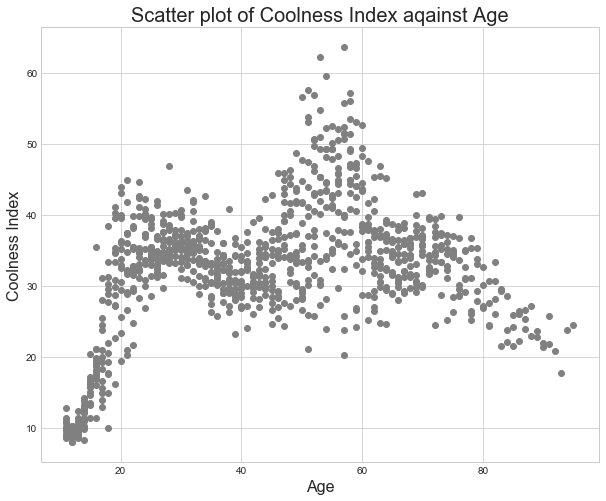

In [27]:
fig, ax = plt.subplots()
ax.scatter(coolindex['age'], coolindex['coolindex'], c = "gray")
ax.set_xlabel("Age", fontsize = 16)
ax.set_ylabel("Coolness Index", fontsize = 16)
ax.set_title("Scatter plot of Coolness Index aqainst Age", fontsize = 20)

#### Part ( b ) : Use OLS regression to fit a stepwise function to these data 

In [28]:
age = coolindex["age"]
CI = coolindex["coolindex"]
age_11_22 = ((age >= 11) & (age < 22)).astype(int)
age_22_40 = ((age >= 22) & (age < 40)).astype(int)
age_40_59 = ((age >= 40) & (age < 59)).astype(int)
age_59_77 = ((age >= 59) & (age < 77)).astype(int)
age_77_95 = ((age >= 77) & (age <= 95)).astype(int)
X_step = pd.DataFrame(dict(age_11_22=age_11_22, age_22_40=age_22_40,
                           age_40_59=age_40_59, age_59_77=age_59_77,
                           age_77_95=age_77_95))

In [29]:
reg = sm.OLS(endog=CI, exog=X_step, missing='drop')
reg_results = reg.fit()
y_pred_1 = reg_results.predict(X_step)

##### (1) Plot this step function

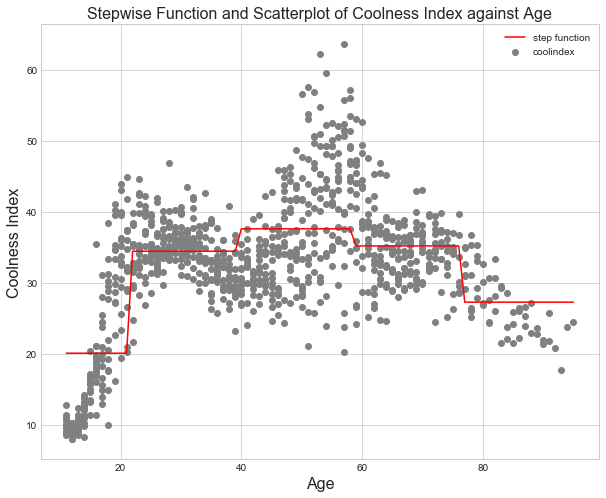

In [30]:
ax.plot(age, y_pred_1, color = 'red', label ="step function")
ax.set_title("Stepwise Function and Scatterplot of Coolness Index against Age",fontsize = 16)
ax.legend()
fig

##### (2) Report your estimated step function values for each bin

The estimated $\beta_{1}$ to $\beta_{5}$ are as follows:

In [31]:
for i in range(5):
    print("Beta_{} = {}".format(i+1, reg_results.params[i]))

Beta_1 = 20.102457252090748
Beta_2 = 34.475788077559386
Beta_3 = 37.63510549244962
Beta_4 = 35.225400040242754
Beta_5 = 27.296378244321282


##### (3) What is the predicted coolness of a 73-year  old from the step function ?

In [32]:
print("The predicted coolness of a 73-year old is")
reg_results.params[3]

The predicted coolness of a 73-year old is


35.225400040242754

#### Part ( c ) : Fit a linear spline to the data over the 5 age bins from part ( b ).

##### (1) Plot the linear spline

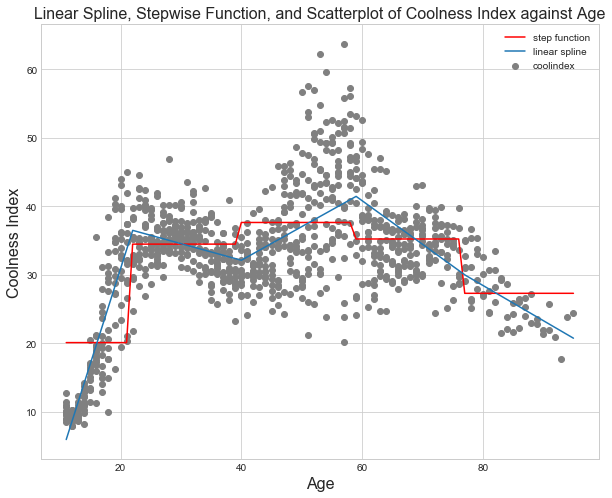

In [33]:
knots = [22, 40, 59, 77]
spl_ci = LSQUnivariateSpline(coolindex.age.values, coolindex.coolindex.values, knots, k=1)
age_vec = np.linspace(coolindex.age.values.min(), coolindex.age.values.max(), 1000)
ax.plot(age_vec, spl_ci(age_vec), label = "linear spline")
ax.legend()
ax.set_title("Linear Spline, Stepwise Function, and Scatterplot of Coolness Index against Age", fontsize = 16)

fig

##### (2) What is the predicted coolness of a 73-year  old from the linear spline ?

In [34]:
print("The predicted coolness of a 73-year old from linear spline is")
print(spl_ci(73))

The predicted coolness of a 73-year old from linear spline is
32.536832389143306


#### Part ( d ) : Fit a cubic spline to the data over the 5 age bins from part ( b ).

##### (1) Plot the cubic spline

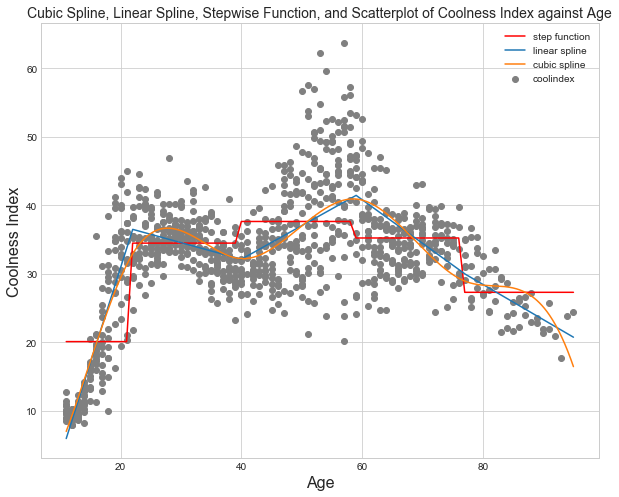

In [35]:
cubspl_ci = LSQUnivariateSpline(coolindex.age.values, coolindex.coolindex.values, knots, k=3)
age_vec = np.linspace(coolindex.age.values.min(), coolindex.age.values.max(), 1000)
ax.plot(age_vec, cubspl_ci(age_vec), label = "cubic spline")
ax.legend()
ax.set_title("Cubic Spline, Linear Spline, Stepwise Function, and Scatterplot of Coolness Index against Age", 
             fontsize = 14)

fig

##### (2) What is the predicted coolness of a 73-year old from the cubic spline ?

In [36]:
print("The predicted coolness of a 73-year old from cubic spline is")
print(cubspl_ci(73))

The predicted coolness of a 73-year old from cubic spline is
31.262429389257864
